<a href="https://colab.research.google.com/github/alecbidaran/Simple-deep-learning-projects/blob/main/GCN_Kinetics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral

     |████████████████████████████████| 102kB 4.3MB/s 


# st-GCN

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam,SGD,schedules
from tensorflow.keras.regularizers import l2
from spektral.datasets import mnist
from spektral.layers import GraphConv,diff_pool,GlobalAvgPool
from spektral.layers.ops import sp_matrix_to_sp_tensor
import pickle
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
tf.compat.v1.disable_eager_execution()
import numpy as np
import functools
import tqdm
import matplotlib.pyplot as plt
import os


In [ ]:
def edge2mat(link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A

num_node = 18
self_link = [(i, i) for i in range(num_node)]
inward = [(4, 3), (3, 2), (7, 6), (6, 5), (13, 12), (12, 11), (10, 9), (9, 8),
          (11, 5), (8, 2), (5, 1), (2, 1), (0, 1), (15, 0), (14, 0), (17, 15),
          (16, 14)]
outward = [(j, i) for (i, j) in inward]
neighbor = inward + outward

In [ ]:
def load_train_data():
  X=np.load("/content/drive/My Drive/datasets/kinetic_preprocessed/Train_data.npy")
  Y=pickle.load(open("/content/drive/My Drive/datasets/kinetic_preprocessed/Train_label.pkl","rb"))
  adj=edge2mat(neighbor+self_link,num_node)
  return adj,X,Y


In [ ]:
def load_test_data():
  X=np.load("/content/drive/My Drive/datasets/kinetic_preprocessed/Test_data.npy")
  Y=pickle.load(open("/content/drive/My Drive/datasets/kinetic_preprocessed/Test_label.pkl","rb"))
  adj=edge2mat(neighbor+self_link,num_node)
  return adj,X,Y


In [ ]:
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size =16     # Batch size
epochs =50      # Number of training epochs
es_patience = 50    # Patience fot early stopping

In [ ]:
A,X,Y=load_train_data()
A1,X1,Y1=load_test_data()

In [ ]:
X=X.reshape(X.shape[0],X.shape[2],X.shape[1]).astype('f4')
X1=X1.reshape(X1.shape[0],X1.shape[2],X1.shape[1]).astype('f4')

In [ ]:
N=X.shape[1]
F=X.shape[2]

In [ ]:
Y=Y.to_numpy()
Y1=Y1.to_numpy()


In [ ]:
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
y=LabelEncoder().fit_transform(Y)
y=tf.keras.utils.to_categorical(y)
y1=LabelEncoder().fit_transform(Y1)
y1=tf.keras.utils.to_categorical(y1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y1.shape[0]/9*300

450000.0

In [ ]:
y.shape

(108000, 9)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
fltr =GraphConv.preprocess(A).astype('f4')
X_in=Input(shape=(N,F))
A_in=Input(tensor=sp_matrix_to_sp_tensor(fltr))
gcn1=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([X_in,A_in])
gcn2=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn1,A_in])
gcn3=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn2,A_in])
gcn4=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn3,A_in])
gcn5=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn4,A_in])
gcn6=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn5,A_in])
gcn7=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn6,A_in])
gcn8=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn7,A_in])
gcn9=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn8,A_in])
globe=Flatten()(gcn9)
fc=Dense(512,activation='relu')(globe)
dense=Dense(9,activation="softmax")(fc)


In [ ]:
gcn=Model(inputs=[X_in,A_in],outputs=dense)
gcn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 18, 3)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(18, 18)]           0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 18, 64)       192         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 18, 64)       4096        graph_conv[0][0]      

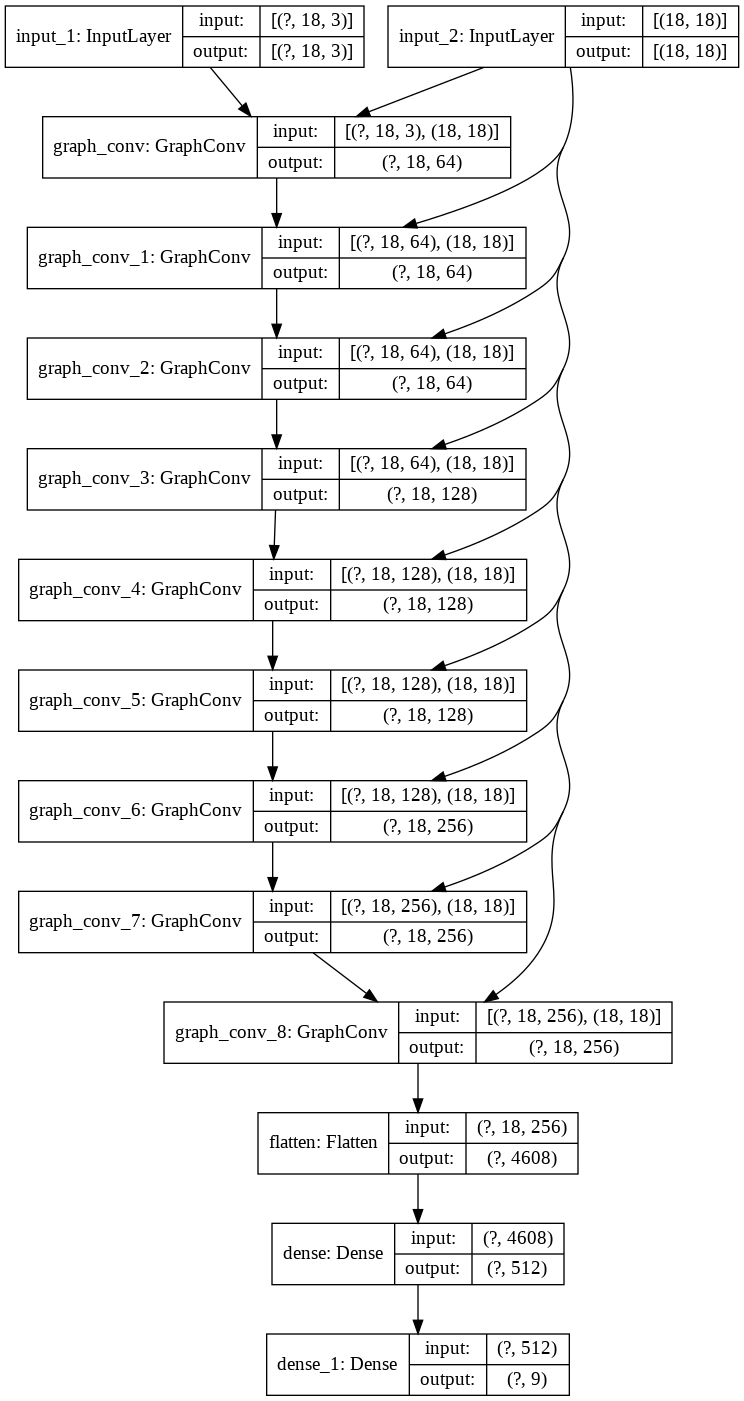

In [ ]:
tf.keras.utils.plot_model(gcn,to_file='gcn.png',show_shapes=True)

In [ ]:
lr_sched=keras.optimizers.schedules.ExponentialDecay(0.1,decay_steps=1000,decay_rate=1e-4,staircase=True)
#model.compile(optimizer=Adam(learning_rate),loss='categorical_crossentropy',metrics=[keras.metrics.TopKCategoricalAccuracy(k=5)])
#lr_sched=keras.optimizers.schedules.ExponentialDecay(0.01,decay_steps=10e2,decay_rate=1e-4,staircase=True)
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
gcn.compile(optimizer=SGD(0.01,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])


In [ ]:
def scheduler(epoch, lr):
  if epoch<10:
    return lr 
  else:
    return lr*tf.math.exp(-0.1)

In [ ]:
sched = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
earlystopping=EarlyStopping(min_delta=0.1,patience=es_patience,restore_best_weights=True)
callbacks=[earlystopping,sched,ReduceLROnPlateau()]

In [ ]:
history=gcn.fit(x_train,y_train,batch_size=32,epochs=100,validation_data=(x_test,y_test),callbacks=callbacks,shuffle=True)

Train on 86400 samples, validate on 21600 samples
Epoch 1/100
86400/86400 [==============================] - ETA: 0s - loss: 2.4866 - top5acc: 0.7429 - top1acc: 0.2296WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
86400/86400 [==============================] - 26s 297us/sample - loss: 2.4866 - top5acc: 0.7429 - top1acc: 0.2296 - val_loss: 2.3293 - val_top5acc: 0.7663 - val_top1acc: 0.2691
Epoch 2/100
86400/86400 [==============================] - 25s 290us/sample - loss: 2.2155 - top5acc: 0.7881 - top1acc: 0.2818 - val_loss: 2.1326 - val_top5acc: 0.7961 - val_top1acc: 0.2918
Epoch 3/100
86400/86400 [==============================] - 25s 290us/sample - loss: 2.0715 - top5acc: 0.8037 - 

Text(0, 0.5, 'percent')

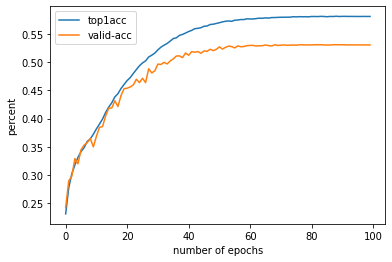

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['top1acc'],label='top1acc')
plt.plot(history.history['val_top1acc'],label='valid-acc')
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("accuracy")


Text(0, 0.5, 'percent')

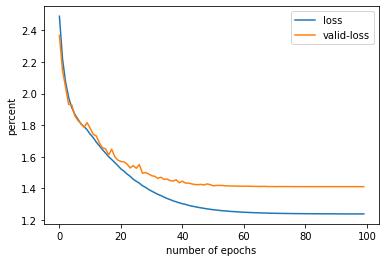

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='valid-loss')
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("loss")

In [ ]:
gcn.evaluate(x_test,y_test)

[1.4116516529189216, 0.8938889, 0.53050923]

In [ ]:
gcn.evaluate(X1,y1)

[1.27372511169204, 0.9075463, 0.57096297]

In [ ]:
pred1=gcn.predict(X1[40*300:60*300])

In [ ]:
y1[40*300:60*300]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
pred1.shape

(6000, 9)

In [ ]:
np.mean(np.amax(pred1[5000:6000],axis=0))


0.8110987

In [ ]:
y_train1[40:50]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
gcn.save_weights("st-gcn.h5")

#CONcatinate

In [ ]:
!unrar x '/content/drive/My Drive/datasets/kinetics-400/RGB.rar'
!unrar x '/content/drive/My Drive/datasets/kinetics-400/Flow.rar'

Streaming output truncated to the last 5000 lines.
Extracting  images/Arm/Single Arm Towel Row With Rotation15.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation16.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation17.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation18.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation19.jpg            5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation6.jpg             5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation8.jpg             5%  OK 
Extracting  images/Arm/Single Arm Towel Row With Rotation9.jpg             5%  OK 
Extracting  images/Arm/Single Arm Trunk Rotation with Cable10.jpg          5%  OK 
Extracting  images/Arm/Single Arm Trunk Rotation with Cable11.jpg          5%  OK 
Extracting  images/Arm/Single

In [ ]:
Denisty_dir='/content/images'
RGB_train='/content/RGB'


In [ ]:
RGB_train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,validation_split=0.3)
RGB_test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1,validation_split=0.04)
flow_train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./(255),zoom_range=0.2,horizontal_flip=True,validation_split=0.3)
flow_test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1,validation_split=0.04)

In [ ]:
train_RGB_batch=RGB_train_datagen.flow_from_directory(RGB_train,target_size=(224,224),color_mode='rgb', classes=None, class_mode='categorical', batch_size=16, shuffle=True,subset='training')
test_RGB_batch=RGB_train_datagen.flow_from_directory(RGB_train,target_size=(224,224),color_mode='rgb',classes=None, class_mode='categorical',batch_size=16,shuffle=False,subset='validation',save_prefix='aug')
#test_RGB_batch=test_datagen.flow_from_directory(RGB_test,target_size=(224,224),batch_size=8,shuffle=True)
#test_RGB_batch=test_datagen.flow_from_directory(RGB_test,target_size=(224,224),batch_size=8,shuffle=True)
train_Dense_batch=flow_train_datagen.flow_from_directory(Denisty_dir,target_size=(224,224),color_mode='rgb', classes=None, class_mode='categorical', batch_size=16, shuffle=True,subset='training')
test_Dense_batch=flow_test_datagen.flow_from_directory(Denisty_dir,target_size=(224,224),color_mode='rgb',classes=None, class_mode='categorical',batch_size=16,shuffle=False,subset='validation',save_prefix='aug')
#test_RGB_batch=test_datagen.flow_from_directory(RGB_test,target_size=(224,224),batch_size=8,shuffle=True)


Found 2947 images belonging to 9 classes.
Found 1257 images belonging to 9 classes.
Found 3785 images belonging to 9 classes.
Found 212 images belonging to 9 classes.


In [ ]:
mobile_net_backend=keras.applications.MobileNet(input_shape=(224,224,3),weights='imagenet',include_top=False)

In [ ]:
for layer in mobile_net_backend.layers:
    layer.trainable=False

In [ ]:
def create_model():
  flatten=keras.layers.Flatten()(mobile_net_backend.output)
  Dense1=keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(flatten)
  dropout=keras.layers.Dropout(0.5)(Dense1)
  classification=keras.layers.Dense(9,activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(dropout)
  model=keras.models.Model(inputs=mobile_net_backend.inputs,outputs=classification)
  return model

In [ ]:
RGB_model=create_model()
RGB_model.load_weights("/content/drive/My Drive/nets/augfitness_RGB30.h5")

In [ ]:
flow_model=create_model()
flow_model.load_weights("/content/drive/My Drive/nets/kinetics_FLow_mobilenet.h5")

In [ ]:
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
RGB_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
flow_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])


In [ ]:
RGB_model.evaluate(test_RGB_batch)


[7.694351287115188, 0.7891566, 0.5301205]

In [ ]:
flow_model.evaluate(test_Dense_batch)

[7.170740757669721, 0.6462264, 0.2028302]

In [ ]:
test_RGB_batch.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
pred1=RGB_model.predict(test_RGB_batch)
pred1

array([[9.99672651e-01, 2.52321342e-07, 1.93414002e-04, ...,
        2.67909836e-05, 1.43248508e-06, 5.99176209e-10],
       [9.99925852e-01, 2.76814771e-09, 3.49629295e-06, ...,
        3.33474345e-05, 1.72672809e-08, 3.06501595e-11],
       [9.99963164e-01, 1.78787973e-09, 1.13575325e-05, ...,
        9.12446649e-06, 1.21916583e-08, 1.17222218e-10],
       ...,
       [3.05304184e-06, 3.16192512e-08, 2.79703800e-05, ...,
        4.11693582e-05, 2.05898800e-08, 9.67057168e-01],
       [2.15118234e-06, 6.15459950e-09, 6.36072655e-05, ...,
        4.64288132e-06, 1.77213000e-08, 9.74728942e-01],
       [3.30572476e-08, 7.97985365e-07, 8.41926703e-06, ...,
        4.99569160e-06, 9.14783416e-10, 9.99744713e-01]], dtype=float32)

In [ ]:
pred2=flow_model.predict(test_Dense_batch)
pred2

array([[9.27840173e-02, 1.26372963e-01, 5.05740345e-02, ...,
        3.37432511e-02, 1.18901506e-01, 4.58944961e-03],
       [8.48269556e-03, 1.75715894e-01, 2.97778770e-02, ...,
        1.66724008e-02, 7.46324286e-02, 1.72954910e-02],
       [2.98169672e-01, 1.14770375e-01, 5.65723889e-02, ...,
        4.14458029e-02, 6.76636696e-02, 2.49471609e-02],
       ...,
       [4.99605609e-04, 5.16800676e-04, 1.28885382e-03, ...,
        6.95699651e-04, 6.67940709e-04, 8.34947079e-03],
       [4.71985142e-04, 8.09241756e-05, 6.34909887e-03, ...,
        3.46129382e-05, 2.73213955e-04, 5.64103127e-01],
       [8.52291472e-03, 9.28955436e-01, 1.05356574e-02, ...,
        3.23650008e-03, 1.85866811e-04, 2.71448283e-04]], dtype=float32)

In [ ]:
con=np.array([pred1[790:790+80],pred2[974:974+47]])
best_score=np.max(np.mean(con,axis=0),axis=1)
best_score=best_score[best_score>0.54]
np.mean(best_score)
#best_score

0.7338874

In [ ]:
Arm=[0.66]
bench_press=[0.50]
deadlift=[0.64]
front_raise=[0.65]
lunge=[0.71]
pullups=[0.76]
pushups=[0.66]
squat=[0.61]
zumba=[0.73]

In [ ]:
np.mean([0.66,0.50,0.64,0.65,0.71,0.76,0.66,0.61,0.73])

0.6577777777777778

In [ ]:
test_RGB_batch.classes[790:790+80]

array([7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8], dtype=int32)

In [ ]:
test_Dense_batch.classes[974:974+80]

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)

In [ ]:
test_RGB_batch.class_indices

{'Arm': 0,
 'benchpress': 1,
 'deadlift': 2,
 'frontraise': 3,
 'lunge': 4,
 'pullups': 5,
 'pushups': 6,
 'squats': 7,
 'zumba': 8}

# RGB+Graph

In [ ]:
test_RGB_batch.classes[1120:1140]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
      dtype=int32)

In [ ]:
np.argmax(y1[340*300:360*300],axis=1)

array([8, 8, 8, ..., 8, 8, 8])

In [ ]:
pred1[1180:1200]

array([[1.60882279e-04, 3.33924581e-05, 9.02837142e-03, 1.58479984e-03,
        7.49722898e-01, 3.54163859e-07, 1.06264330e-01, 1.33199677e-01,
        5.30478064e-06],
       [6.19197449e-09, 3.45067965e-04, 3.99963369e-08, 6.88665409e-08,
        5.49134427e-09, 9.40848549e-05, 6.52964571e-09, 9.99560654e-01,
        2.02794690e-13],
       [9.79844231e-07, 1.01750693e-03, 5.79214543e-09, 1.78673836e-05,
        2.51500182e-07, 2.32312027e-02, 3.13336130e-08, 9.75732207e-01,
        7.47065521e-10],
       [2.40417741e-10, 5.11220080e-08, 7.17619332e-06, 4.59128513e-09,
        5.51611090e-10, 2.13431637e-08, 6.62788935e-09, 9.99992728e-01,
        5.98117543e-14],
       [7.53599977e-07, 3.32651567e-03, 2.44420698e-05, 5.09315647e-08,
        9.42559719e-09, 3.05517133e-05, 5.51811013e-07, 9.96617138e-01,
        2.34209408e-13],
       [2.74562382e-07, 1.39503996e-03, 6.73702205e-09, 1.61761964e-05,
        9.02126018e-08, 4.34408244e-03, 3.34563310e-08, 9.94244277e-01,
        9.2

In [ ]:
pred_graph=gcn.predict(X1[340*300:360*300])
pred_graph

array([[1.5634758e-02, 9.5018540e-03, 4.1192174e-02, ..., 4.7242429e-02,
        2.2912892e-02, 2.8553885e-01],
       [1.8553529e-02, 4.3095564e-03, 5.0776664e-02, ..., 1.5645519e-02,
        5.7490300e-02, 1.6839959e-01],
       [3.6863405e-02, 4.1150260e-03, 5.7402857e-02, ..., 1.3715844e-02,
        6.0148701e-02, 2.4066713e-01],
       ...,
       [6.7709982e-03, 1.8955905e-05, 2.5853806e-03, ..., 4.4584272e-07,
        5.0848662e-03, 9.4723338e-01],
       [1.3969727e-02, 7.0618116e-06, 4.2488701e-03, ..., 6.4316708e-07,
        1.4168252e-02, 8.3252501e-01],
       [1.9913539e-02, 7.7998127e-05, 7.7545815e-03, ..., 2.5867382e-06,
        2.8291691e-02, 7.7844095e-01]], dtype=float32)

In [ ]:
pred_frame=[]
for i in range(300,6300,300):
  pred=pred_graph[:i]
  best_value=np.mean(pred,axis=0)
  pred_frame.append(best_value)

In [ ]:
pred_frame=np.array(pred_frame)
pred_frame

array([[0.08737262, 0.07214933, 0.09848532, 0.13952962, 0.20582968,
        0.10068447, 0.06352688, 0.0986433 , 0.13377811],
       [0.06436548, 0.06160286, 0.07617439, 0.07679798, 0.13446023,
        0.09324481, 0.04319097, 0.07024074, 0.37992203],
       [0.06244668, 0.05538647, 0.11002932, 0.05515677, 0.11882968,
        0.08880126, 0.03706763, 0.07331441, 0.39896765],
       [0.06148787, 0.0448265 , 0.09516599, 0.04461849, 0.10002697,
        0.08363003, 0.02848056, 0.08069099, 0.46107244],
       [0.06723887, 0.04548346, 0.09289877, 0.05125331, 0.1016173 ,
        0.08689868, 0.02912367, 0.07929413, 0.4461919 ],
       [0.0643641 , 0.0435626 , 0.08900563, 0.04976344, 0.09497152,
        0.08366849, 0.02854236, 0.07304565, 0.47307652],
       [0.05969476, 0.04317229, 0.0813942 , 0.04553914, 0.08924372,
        0.0867982 , 0.02629965, 0.0726672 , 0.4951912 ],
       [0.05716243, 0.05206743, 0.07946485, 0.04747034, 0.08817117,
        0.09142293, 0.02669169, 0.07637806, 0.48117143],


In [ ]:
con=np.array([pred1[1180:1200],pred_frame])
best_score=np.max(np.mean(con,axis=0),axis=1)
best_score=best_score[best_score>0.48]
#np.mean(best_score)
best_score

array([0.5349007 , 0.5245233 , 0.54034185, 0.53795564, 0.533645  ,
       0.5020891 , 0.5290719 , 0.616974  , 0.66219497, 0.68823624,
       0.71389025, 0.71881425, 0.7054067 , 0.67100525, 0.60049546],
      dtype=float32)

In [ ]:
np.max(best_score)

0.7398725

In [ ]:
ArmG=[0.80]
bench_pressG=[0.74321365]
deadliftG=[0.88]
front_raiseG=[0.72]
lungeG=[0.6]
pullupsG=[0.75]
pushupsG=[0.84]
squatG=[0.73]
zumbaG=[0.72]

In [ ]:
np.mean([ArmG,bench_pressG,deadliftG,front_raiseG,lungeG,pullupsG,pushupsG,squatG,zumbaG])

0.7536904055555556

In [ ]:
np.mean([Arm,ArmG,bench_press,bench_pressG,deadlift,deadliftG,front_raise,front_raiseG,lunge,lungeG,pullups,pullupsG,pushups,pushupsG,squat,squatG,zumba,zumbaG])

0.7057340916666668

# saving model

In [ ]:
fltr =GraphConv.preprocess(A).astype('f4')
X_in=Input(shape=(N,F))
A_in=Input(tensor=sp_matrix_to_sp_tensor(fltr))
gcn1=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([X_in,A_in])
gcn2=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn1,A_in])
gcn3=GraphConv(64,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn2,A_in])
gcn4=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn3,A_in])
gcn5=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn4,A_in])
gcn6=GraphConv(128,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn5,A_in])
gcn7=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn6,A_in])
gcn8=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn7,A_in])
gcn9=GraphConv(256,activation='elu',use_bias=False,kernel_regularizer=l2(l2_reg))([gcn8,A_in])
globe=Flatten()(gcn9)
fc=Dense(512,activation='relu')(globe)
dense=Dense(9,activation="softmax")(fc)


In [ ]:
Gcn=Model(inputs=[X_in,A_in],outputs=dense)


In [ ]:
Gcn.load_weights("/content/st-gcn.h5")

In [ ]:
lr_sched=keras.optimizers.schedules.ExponentialDecay(0.1,decay_steps=1000,decay_rate=1e-4,staircase=True)
#model.compile(optimizer=Adam(learning_rate),loss='categorical_crossentropy',metrics=[keras.metrics.TopKCategoricalAccuracy(k=5)])
#lr_sched=keras.optimizers.schedules.ExponentialDecay(0.01,decay_steps=10e2,decay_rate=1e-4,staircase=True)
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
Gcn.compile(optimizer=SGD(0.01,momentum=0.9,nesterov=False),loss='categorical_crossentropy',metrics=[top5acc,top1acc])
